In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import seaborn
seaborn.set()
import nltk
from nltk.corpus import stopwords
import re

In [2]:
#import necessary function and module, and the use of stopwords
nltk.download("stopwords")

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CUSTOMPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = pd.read_csv('ign.csv')
dataset.head()

,Unnamed: 0,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12
3,3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11
4,4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18625 entries, 0 to 18624
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      18625 non-null  int64  
 1   score_phrase    18625 non-null  object 
 2   title           18625 non-null  object 
 3   url             18625 non-null  object 
 4   platform        18625 non-null  object 
 5   score           18625 non-null  float64
 6   genre           18589 non-null  object 
 7   editors_choice  18625 non-null  object 
 8   release_year    18625 non-null  int64  
 9   release_month   18625 non-null  int64  
 10  release_day     18625 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.6+ MB


In [5]:
#Drop unused column, unnamed: 0 which indicates the index number and url
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.drop('url', axis=1, inplace=True)
dataset.head()

,score_phrase,title,platform,score,genre,editors_choice,release_year,release_month,release_day
0,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,Great,Splice: Tree of Life,iPad,8.5,Puzzle,N,2012,9,12
3,Great,NHL 13,Xbox 360,8.5,Sports,N,2012,9,11
4,Great,NHL 13,PlayStation 3,8.5,Sports,N,2012,9,11


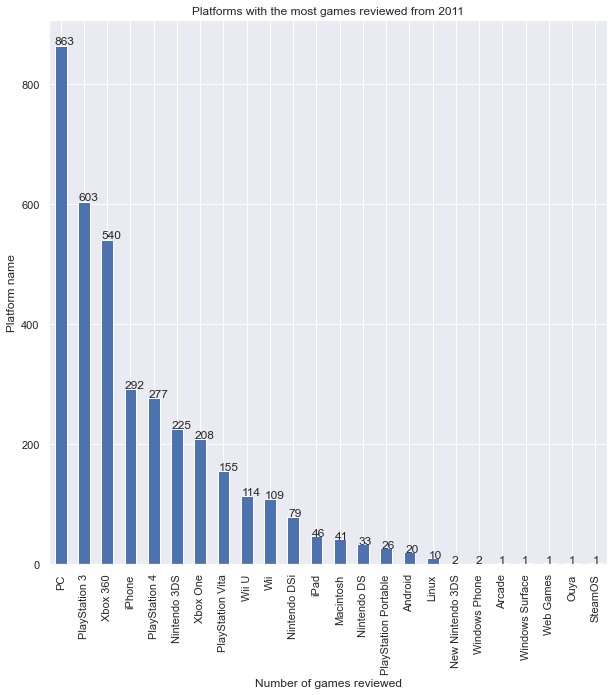

In [6]:
#This cell creates a vertical bar chart showing the platforms with the most game reviews.
platform_data = dataset[dataset['release_year']>=2011]['platform']
ax = platform_data.value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.title('Platforms with the most games reviewed from 2011')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.xlabel('Number of games reviewed')
plt.ylabel('Platform name')
plt.show()

Number of games reviewed in 2016: 226


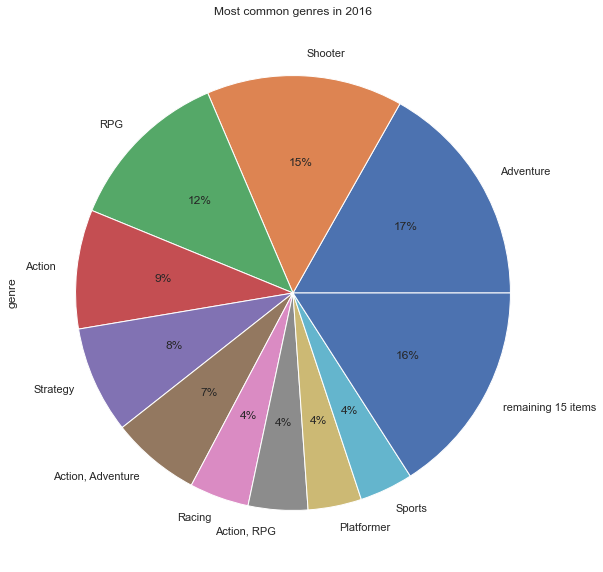

In [7]:
#By searching for all the games released in 2016 and getting the genre of each game, we can see which 
#genres were the most reviewed for that year.
genre_data = dataset[dataset['release_year'] == 2016]['genre']
temp = genre_data.value_counts()
print("Number of games reviewed in 2016:",dataset[dataset['release_year']==2016]['title'].count())
genre_data_top10 = temp.head(10)
genre_data_top10['remaining {0} items'.format(len(temp)-10)] = sum(temp[10:])
genre_data_top10.plot(kind='pie')
plt.title('Most common genres in 2016')
plt.pie(genre_data_top10,autopct='%1.0f%%')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

Number of games reviewed in 2006: 1208


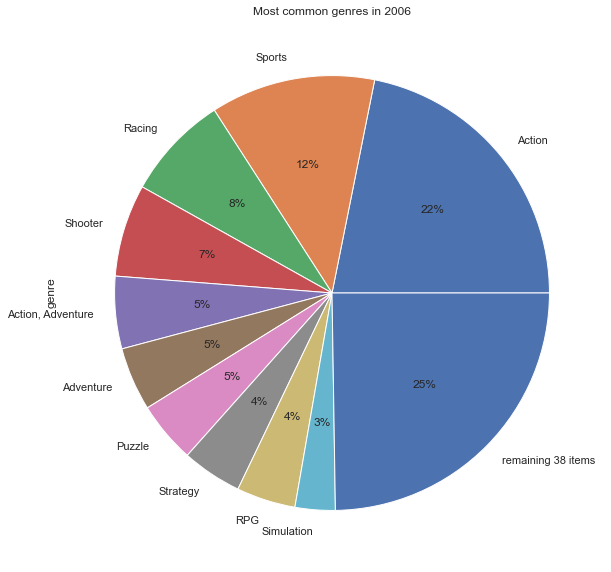

In [8]:
#In order to compare the data found for 2016 to data found for 2006 we can simply change the code to 
#display genres for the year 2006.
genre_data = dataset[dataset['release_year'] == 2006]['genre']
print("Number of games reviewed in 2006:",dataset[dataset['release_year']==2006]['title'].count())
temp = genre_data.value_counts()
genre_data_top10 = temp.head(10)
genre_data_top10['remaining {0} items'.format(len(temp)-10)] = sum(temp[10:])
genre_data_top10.plot(kind='pie')
plt.title('Most common genres in 2006')
plt.pie(genre_data_top10,autopct='%1.0f%%')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

,2009,2010,2003,2011,2004,2008,2005,2007,2002,2012,...,2000,2006,2013,1999,2014,2015,2016,1998,1997,1996
,281,270,267,255,254,252,243,232,228,210,...,167,167,138,100,97,71,45,43,16,8


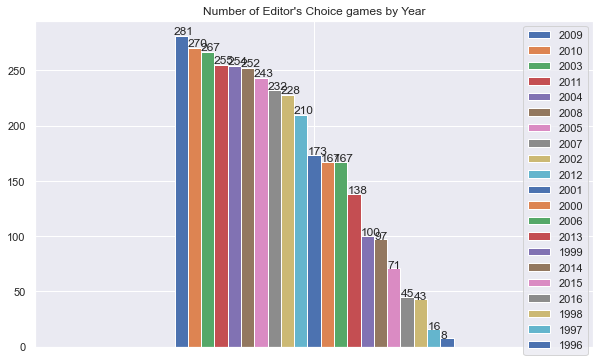

In [9]:
#This cell creates a table showing how many games were listed as "Editor's Choice" for each year and which year 
#has the most "Editor's Choice" games.
ec_year = dataset[dataset['editors_choice']=='Y']['release_year'].value_counts()
df_ecyear = pd.DataFrame([ec_year])
df_ecyear.index = [""]
ax2 = df_ecyear.plot(kind='bar',stacked=False, figsize=(10,6), title="Number of Editor's Choice games by Year")
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


from IPython.display import display
display(df_ecyear)

In [11]:
release_date = dataset.apply(lambda x: pd.datetime.strptime("{0} {1} {2} 00:00:00".format(
            x['release_year'],x['release_month'], x['release_day']), "%Y %m %d %H:%M:%S"),axis=1)
dataset['release_date'] = release_date

In [12]:
dataset[dataset.release_year == 1970]

,score_phrase,title,platform,score,genre,editors_choice,release_year,release_month,release_day,release_date
516,Great,The Walking Dead: The Game -- Episode 1: A New...,Xbox 360,8.5,Adventure,N,1970,1,1,1970-01-01


In [13]:
data = dataset[dataset.release_year > 1970]
len(data)

18624

In [14]:
#Let's look at all score phrases in IGN reviews and average scores of each phrase
data.score_phrase.unique()

data.groupby('score_phrase')['score'].mean().sort_values()

score_phrase
Disaster        0.666667
Unbearable      1.290278
Painful         2.267941
Awful           3.290211
Bad             4.331600
Mediocre        5.318530
Okay            6.366553
Good            7.369099
Great           8.316471
Amazing         9.176663
Masterpiece    10.000000
Name: score, dtype: float64

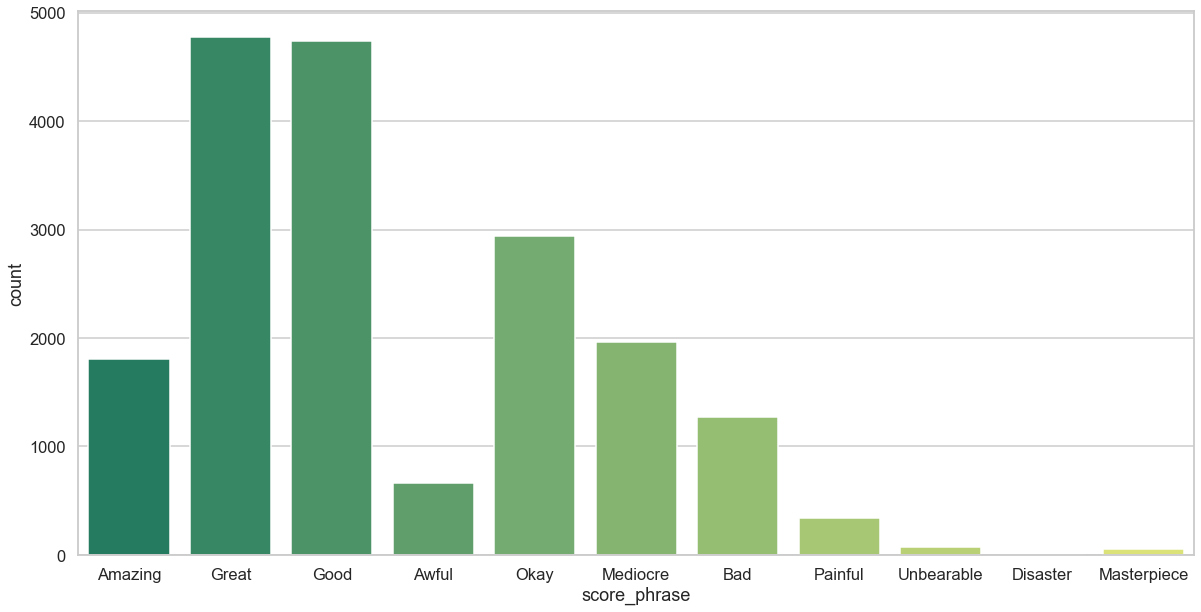

In [15]:
sns.set_style('whitegrid')
countplt, ax=plt.subplots(figsize=(20,10))
ax=sns.countplot(x='score_phrase', data=dataset, palette='summer')

In [16]:
#AMRI YAHYA
#There are all platforms which are found in the dataset:
data.platform.unique()

array(['PlayStation Vita', 'iPad', 'Xbox 360', 'PlayStation 3',
       'Macintosh', 'PC', 'iPhone', 'Nintendo DS', 'Nintendo 3DS',
       'Android', 'Wii', 'PlayStation 4', 'Wii U', 'Linux',
       'PlayStation Portable', 'PlayStation', 'Nintendo 64', 'Saturn',
       'Lynx', 'Game Boy', 'Game Boy Color', 'NeoGeo Pocket Color',
       'Game.Com', 'Dreamcast', 'Dreamcast VMU', 'WonderSwan', 'Arcade',
       'Nintendo 64DD', 'PlayStation 2', 'WonderSwan Color',
       'Game Boy Advance', 'Xbox', 'GameCube', 'DVD / HD Video Game',
       'Wireless', 'Pocket PC', 'N-Gage', 'NES', 'iPod', 'Genesis',
       'TurboGrafx-16', 'Super NES', 'NeoGeo', 'Master System',
       'Atari 5200', 'TurboGrafx-CD', 'Atari 2600', 'Sega 32X', 'Vectrex',
       'Commodore 64/128', 'Sega CD', 'Nintendo DSi', 'Windows Phone',
       'Web Games', 'Xbox One', 'Windows Surface', 'Ouya',
       'New Nintendo 3DS', 'SteamOS'], dtype=object)

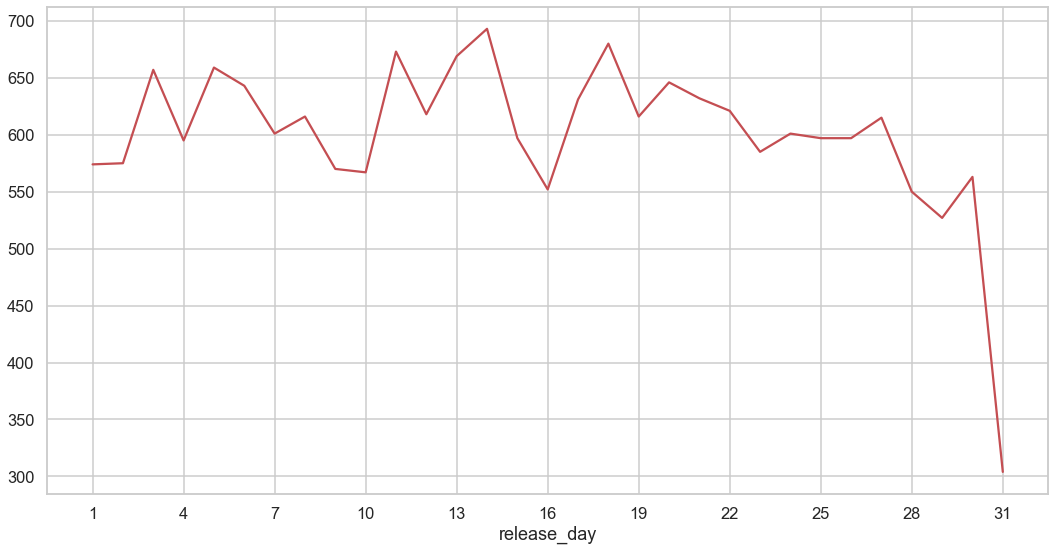

In [17]:
plt.figure(figsize=(15,8))
data.groupby(['release_day']).size().plot(c='r')
plt.xticks(range(1,32,3))
plt.tight_layout()

<AxesSubplot:xlabel='release_year'>

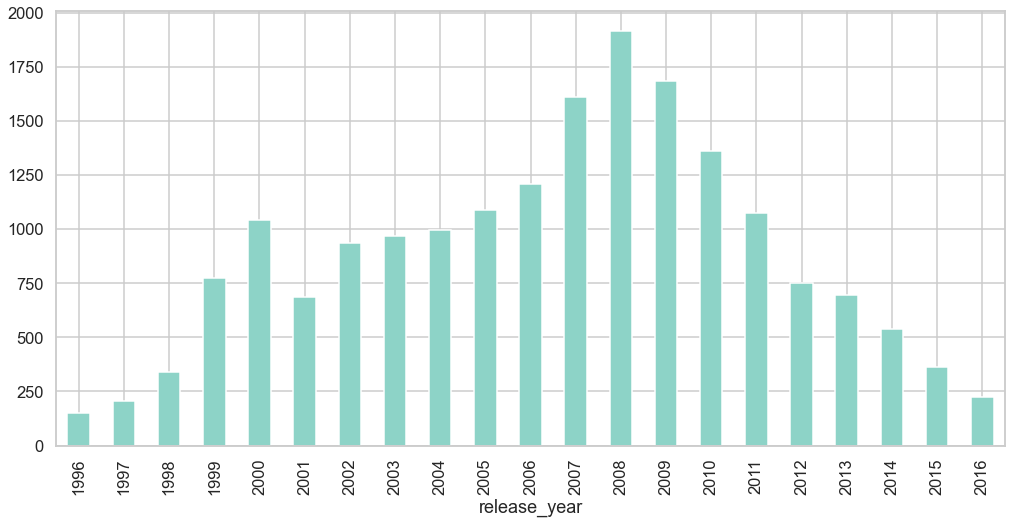

In [18]:
#Games release per year
plt.figure(figsize=(17,8))
data.groupby(['release_year']).size().plot(kind='bar')

Text(0, 0.5, '')

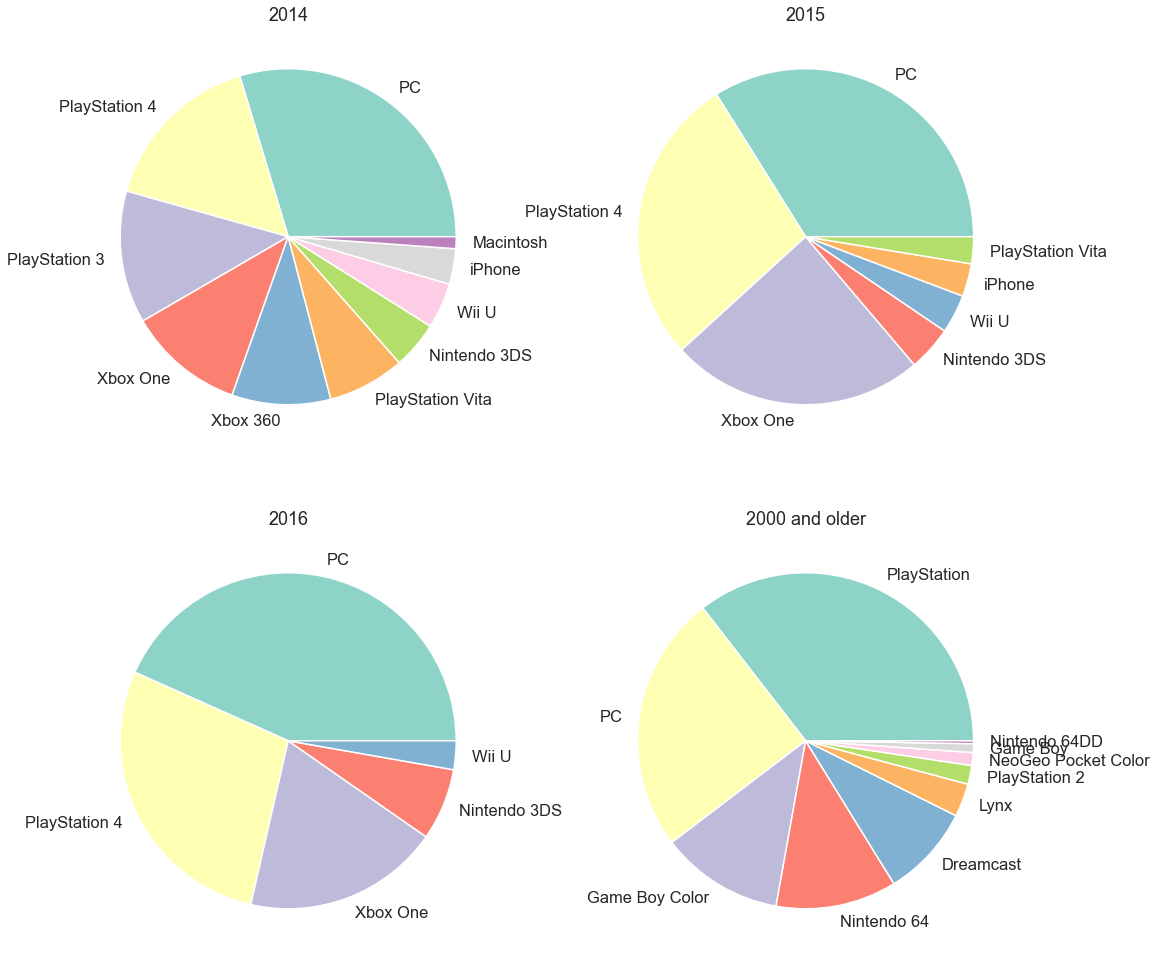

In [19]:
#The top ten most popular gaming platforms
f, ax = plt.subplots(2,2, figsize=(17,17))
last_games = data[data.release_year == 2014]
last_popular = last_games.platform.value_counts()[last_games.platform.value_counts() > 5]
last_popular.plot.pie(ax=ax[0,0])
ax[0,0].set_title('2014')
ax[0,0].set_ylabel('')
last_games = data[data.release_year == 2015]
last_popular = last_games.platform.value_counts()[last_games.platform.value_counts() > 5]
last_popular.plot.pie(ax=ax[0,1])
ax[0,1].set_title('2015')
ax[0,1].set_ylabel('')
last_games = data[data.release_year == 2016]
last_popular = last_games.platform.value_counts()[last_games.platform.value_counts() > 5]
last_popular.plot.pie(ax=ax[1,0])
ax[1,0].set_title('2016')
ax[1,0].set_ylabel('')
old_games = data[data.release_year <= 2000]
old_popular = old_games.platform.value_counts()[old_games.platform.value_counts() > 5]
old_popular.plot.pie(ax=ax[1,1])
ax[1,1].set_title('2000 and older')
ax[1,1].set_ylabel('')

In [20]:
#The left plot is the most popular platform in year. The right is a platform with the most high average score. 
#For this purpose games are chosen that had more 20 releases per year. 
#It is interesting that platforms on the left and right are not the same usually.
years = tuple(range(1996,2017))
s = data.groupby([data.release_year,data.platform]).title.count()
top_years_platform = pd.DataFrame([[i,s[i].max(),s[i].argmax()] for i in years], 
                                 columns=['release_year','count_games','platform'])

sc = data.groupby([data.release_year,data.platform]).score
s = sc.median()[sc.count() > 20]
top_scores_platform = pd.DataFrame([[i,s[i].max(),s[i].argmax()] for i in years], 
                                 columns=['release_year','score_game','platform'])

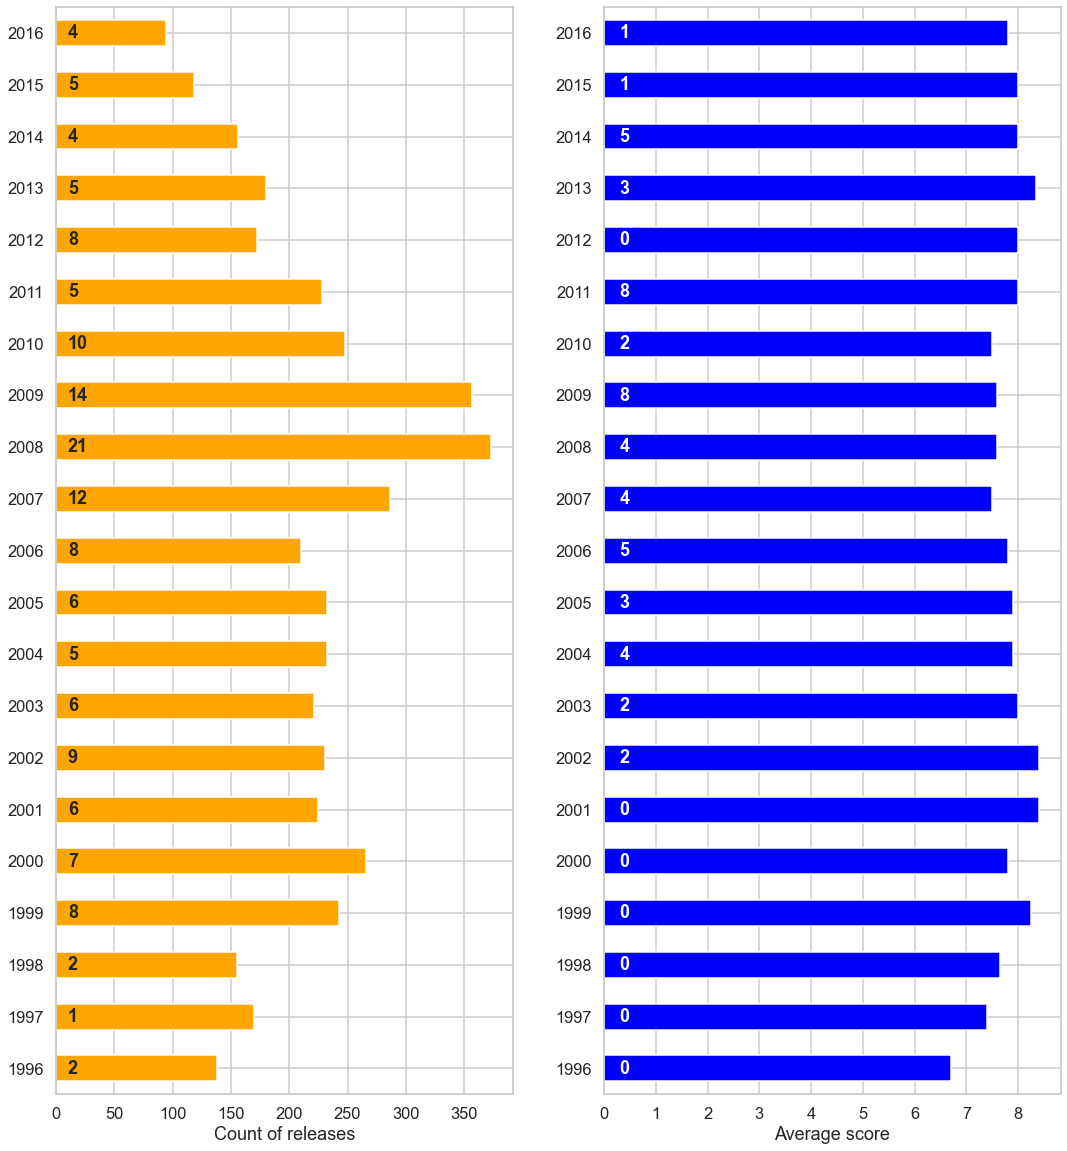

In [21]:
f, axes = plt.subplots(1,2,figsize=(18,20))

ax = top_years_platform.count_games.plot(kind='barh',color='orange',ax=axes[0])
ax.set_yticklabels(years) 
ax.set_xlabel('Count of releases')
rects = ax.patches
for i, v in enumerate(top_years_platform.platform): 
    ax.text(10, i-.1, v, fontweight='bold')

ax2 = top_scores_platform.score_game.plot(kind='barh',color='blue',ax=axes[1])
ax2.set_yticklabels(years) 
ax2.set_xlabel('Average score')
rects = ax2.patches
for i, v in enumerate(top_scores_platform.platform): 
    ax2.text(0.3, i-.1, v, fontweight='bold', color='white')

In [22]:
data_pc = data[data.platform == 'PC']
data_ps = data[data.platform == 'PlayStation']
data_ps2 = data[data.platform == 'PlayStation 2']
data_ps3 = data[data.platform == 'PlayStation 3']
data_ps4 = data[data.platform == 'PlayStation 4']
data_xbox = data[data.platform == 'Xbox']
data_xbox360 = data[data.platform == 'Xbox 360']
data_xbox_one = data[data.platform == 'Xbox One']
df = pd.DataFrame({'PC' : data_pc.groupby('release_year').size(),
                   'PS' : data_ps.groupby('release_year').size(),
                   'PS2' : data_ps2.groupby('release_year').size(),
                   'PS3' : data_ps3.groupby('release_year').size(),
                   'PS4' : data_ps4.groupby('release_year').size(),
                   'Xbox' : data_xbox.groupby('release_year').size(),
                   'Xbox 360' : data_xbox360.groupby('release_year').size(),
                   'Xbox One' : data_xbox_one.groupby('release_year').size()
                  })

<AxesSubplot:ylabel='release_year'>

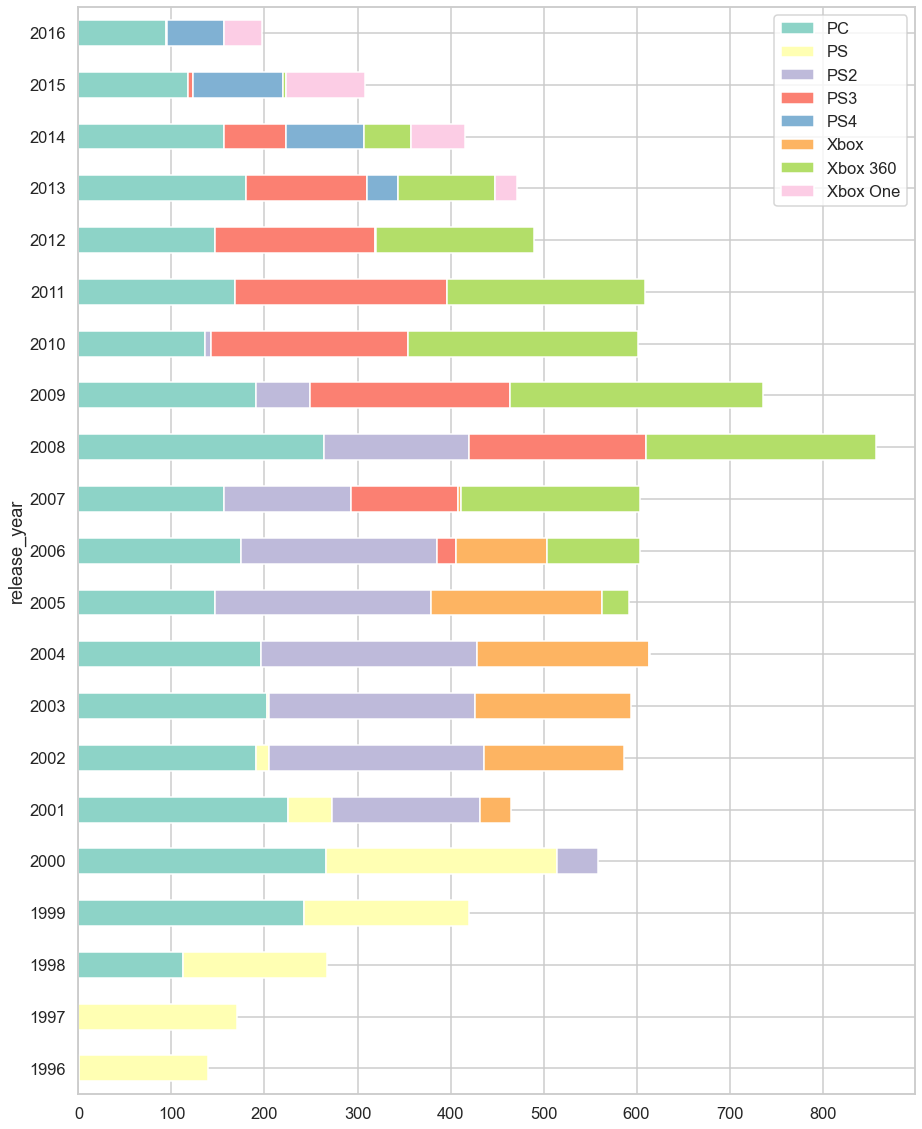

In [23]:
#The plot of the platforms by the year of the review
f,ax = plt.subplots(1,1,figsize=(15,20))
df.plot(kind='barh',stacked=True,ax=ax)

<AxesSubplot:xlabel='release_day', ylabel='score'>

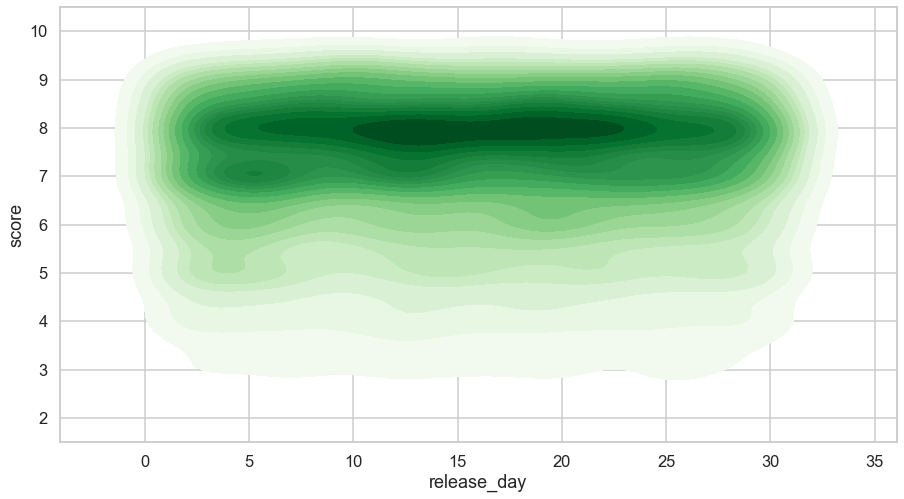

In [24]:
#ADIBUN

#There are joint distribution of density of scores and dates. Darker areas correspond to more typical values. 
#Well we once again see that November is the most popular month among game developers. 
#But now we see one more thing: a typical score is approximately 8. Let's check it out.
plt.figure(figsize=(15,8))
plt.ylim(1.5,10.5)
sns.kdeplot(data.release_day, data.score, n_levels=20, cmap="Greens", shade=True, shade_lowest=False)

<AxesSubplot:xlabel='release_month', ylabel='score'>

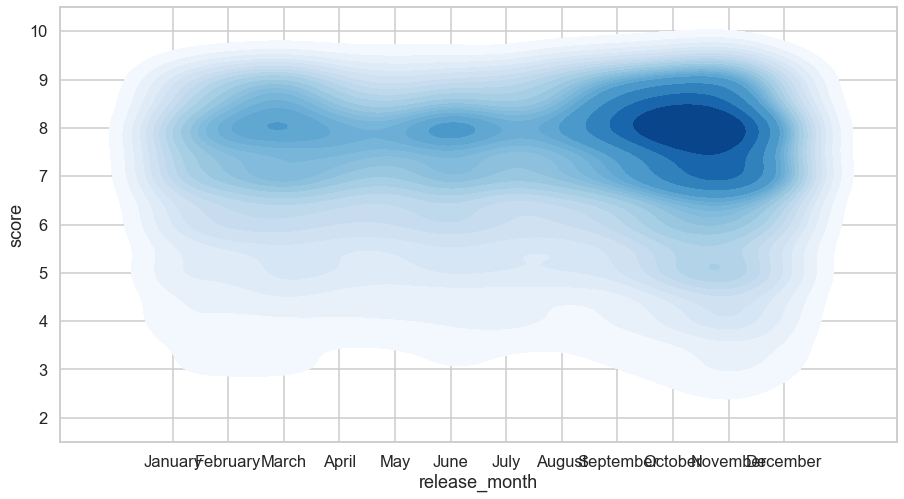

In [25]:
plt.figure(figsize=(15,8))
plt.ylim(1.5,10.5)
plt.xticks(range(1,13),['January','February','March','April','May','June',
            'July','August','September','October','November','December'])
sns.kdeplot(data.release_month, data.score, n_levels=20, cmap="Blues", shade=True, shade_lowest=False)

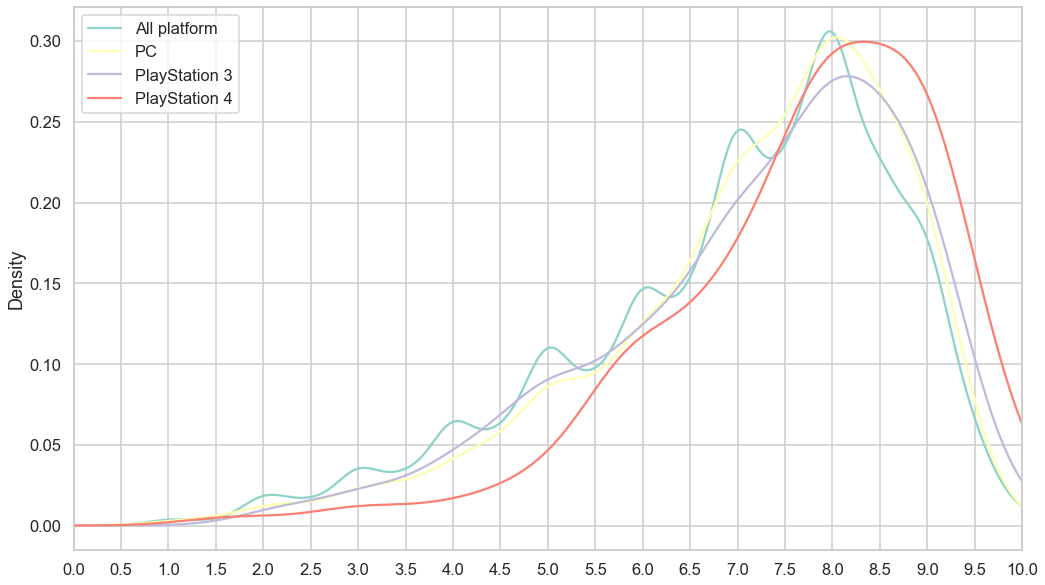

In [26]:
#PC has a peak little bit right than all platforms. The platforms with the highest average scores are 
#Playstation 4, Xbox One and iPad. 
#Playstation 4 has won.
plt.figure(figsize=(17,10))
plt.xticks(np.linspace(0,10,21))
plt.xlim(0,10)
data.score.plot.kde(label='All platform')
data[data.platform == 'PC'].score.plot.kde(label='PC')
#data[data.platform == 'PlayStation'].score.plot.kde(label='PlayStation')
#data[data.platform == 'PlayStation 2'].score.plot.kde(label='PlayStation 2')
data[data.platform == 'PlayStation 3'].score.plot.kde(label='PlayStation 3')
data[data.platform == 'PlayStation 4'].score.plot.kde(label='PlayStation 4')
plt.legend(loc='upper left')

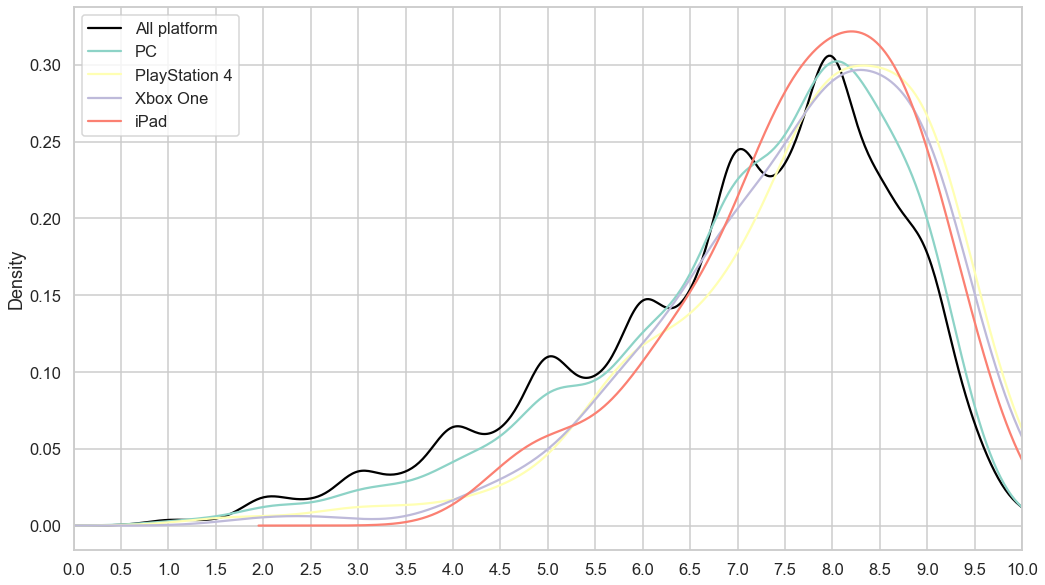

In [27]:
plt.figure(figsize=(17,10))
plt.xticks(np.linspace(0,10,21))
plt.xlim(0,10)
data.score.plot.kde(label='All platform',c='black')
data[data.platform == 'PC'].score.plot.kde(label='PC')
data[data.platform == 'PlayStation 4'].score.plot.kde(label='PlayStation 4')
data[data.platform == 'Xbox One'].score.plot.kde(label='Xbox One')
data[data.platform == 'iPad'].score.plot.kde(label='iPad')
plt.legend(loc='upper left')

In [28]:
#There are all genres in the dataset which have 150 games at least
genres = data.groupby('genre')['genre']
genres_count=genres.count()
large_genres=genres_count[genres_count>=150]
large_genres.sort_values(ascending=False,inplace=True)
large_genres

genre
Action               3797
Sports               1916
Shooter              1610
Racing               1228
Adventure            1174
Strategy             1071
RPG                   980
Platformer            823
Puzzle                776
Action, Adventure     765
Simulation            567
Fighting              547
Music                 371
Action, RPG           330
Racing, Action        210
Puzzle, Action        200
Sports, Action        196
Name: genre, dtype: int64

Text(0.5, 1.0, 'Average scores of games (cell exists if a genre has at least 10 releases in year)')

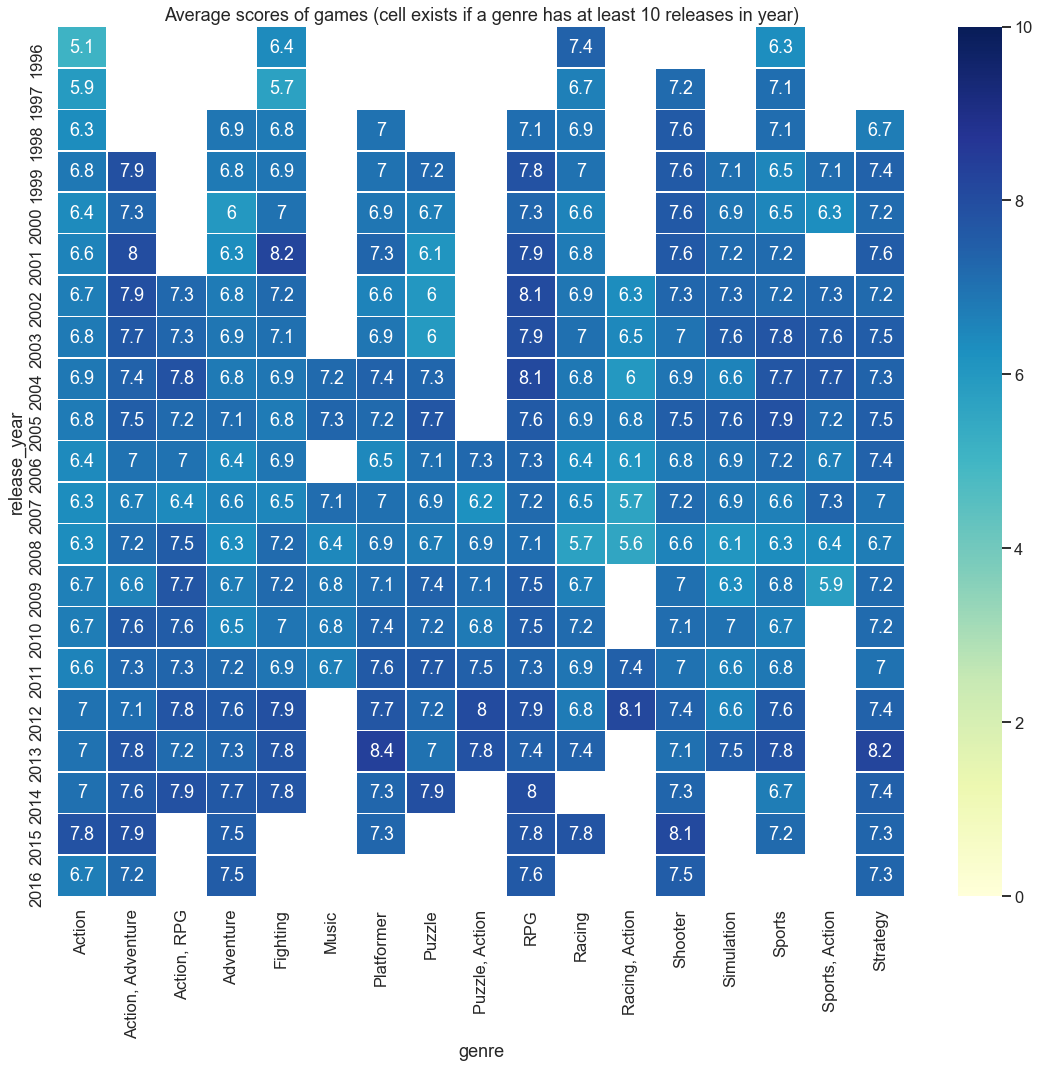

In [29]:
data_genre = data[data.genre.isin(large_genres.keys())]
table_score = pd.pivot_table(data_genre,values=['score'],index=['release_year'],columns=['genre'],aggfunc='mean',margins=False)
table_count = pd.pivot_table(data_genre,values=['score'],index=['release_year'],columns=['genre'],aggfunc='count',margins=False)
table = table_score[table_count > 10]
plt.figure(figsize=(19,16))
sns.heatmap(table.score,linewidths=.5,annot=True,vmin=0,vmax=10,cmap='YlGnBu')
plt.title('Average scores of games (cell exists if a genre has at least 10 releases in year)')

Text(0.5, 1.0, 'Count of games')

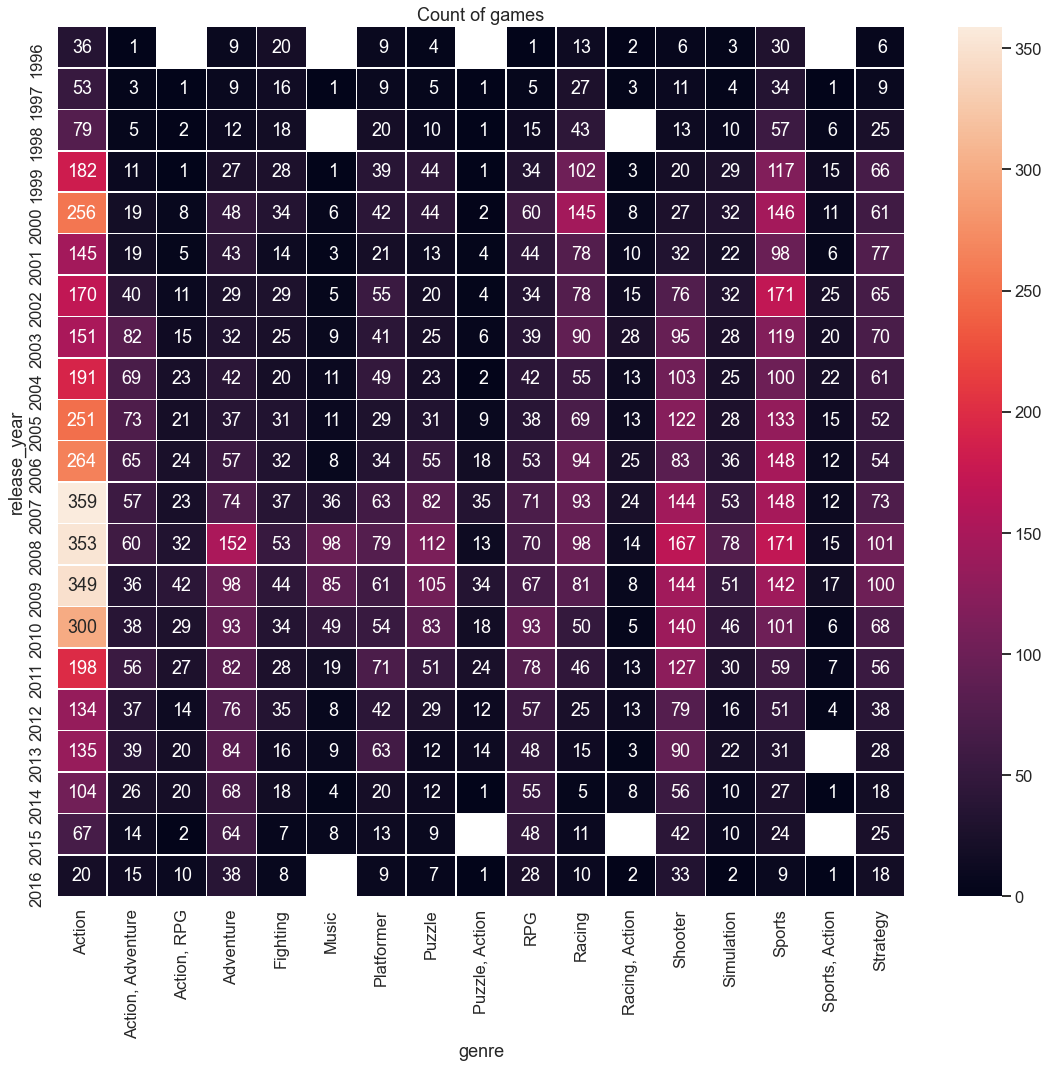

In [30]:
plt.figure(figsize=(19,16))
sns.heatmap(table_count.score,linewidths=.5,annot=True,fmt='2.0f',vmin=0)
plt.title('Count of games')

In [31]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CUSTOMPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
nltk.download('punkt')
t = data.title.apply(nltk.word_tokenize).sum()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CUSTOMPC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
#There are the most common words in games titles.
from collections import Counter
from string import punctuation

def content_text(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    without_stp  = Counter()
    for word in text:
        word = word.lower()
        if len(word) < 3:
            continue
        if word not in stopwords:
            without_stp.update([word])
    return [(y,c) for y,c in without_stp.most_common(20)]

without_stop = content_text(t)
without_stop

[('edition', 421),
 ('world', 388),
 ('game', 371),
 ('star', 291),
 ('wars', 271),
 ('dead', 221),
 ('super', 218),
 ('nba', 212),
 ('episode', 209),
 ('dragon', 207),
 ('racing', 204),
 ('war', 197),
 ('nfl', 196),
 ('iii', 185),
 ('battle', 176),
 ('soccer', 169),
 ('heroes', 164),
 ('pro', 163),
 ('tour', 163),
 ('dark', 149)]

(-0.5, 399.5, 199.5, -0.5)

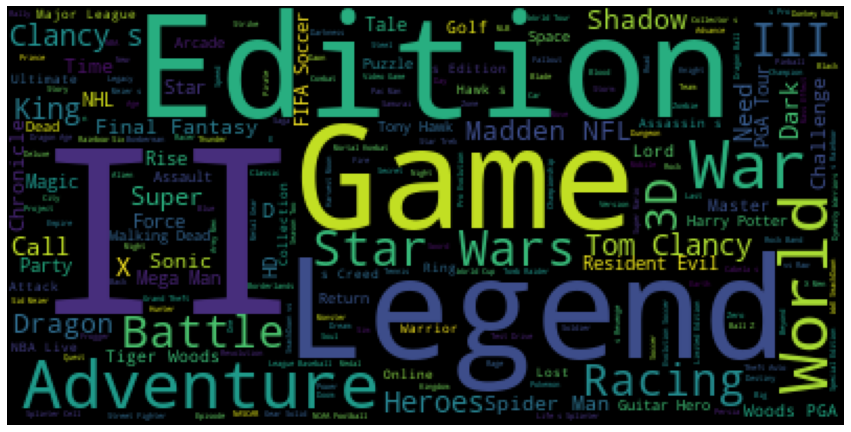

In [34]:
from PIL import Image
import random
from wordcloud import WordCloud, STOPWORDS

text = ' '.join(t)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='black', max_font_size=110, stopwords=stopwords, 
                      random_state=3, relative_scaling=.5).generate(text)
plt.figure(figsize=(15,18))
plt.imshow(wordcloud)
plt.axis('off')

In [35]:
#masterpiece rating games of all time
master = data[data.score == 10][['title','platform','genre','release_year']]
master

,title,platform,genre,release_year
1058,The Legend of Zelda: Ocarina of Time,Nintendo 64,"Action, Adventure",1998
1287,Pokemon Blue Version,Game Boy,RPG,1999
1289,Pokemon Red Version,Game Boy,RPG,1999
1354,Joust,Lynx,Action,1999
1363,Shanghai,Lynx,Puzzle,1999
1408,Checkered Flag,Lynx,Racing,1999
1434,Super Mario Bros. Deluxe,Game Boy Color,Platformer,1999
1457,Soulcalibur,Dreamcast,Fighting,1999
1461,The Legend of Zelda: Link's Awakening DX,Game Boy Color,"Action, Adventure",1999
1592,Mario Golf [Game Boy Color],Game Boy Color,"Sports, Action",1999


Text(0, 0.5, '')

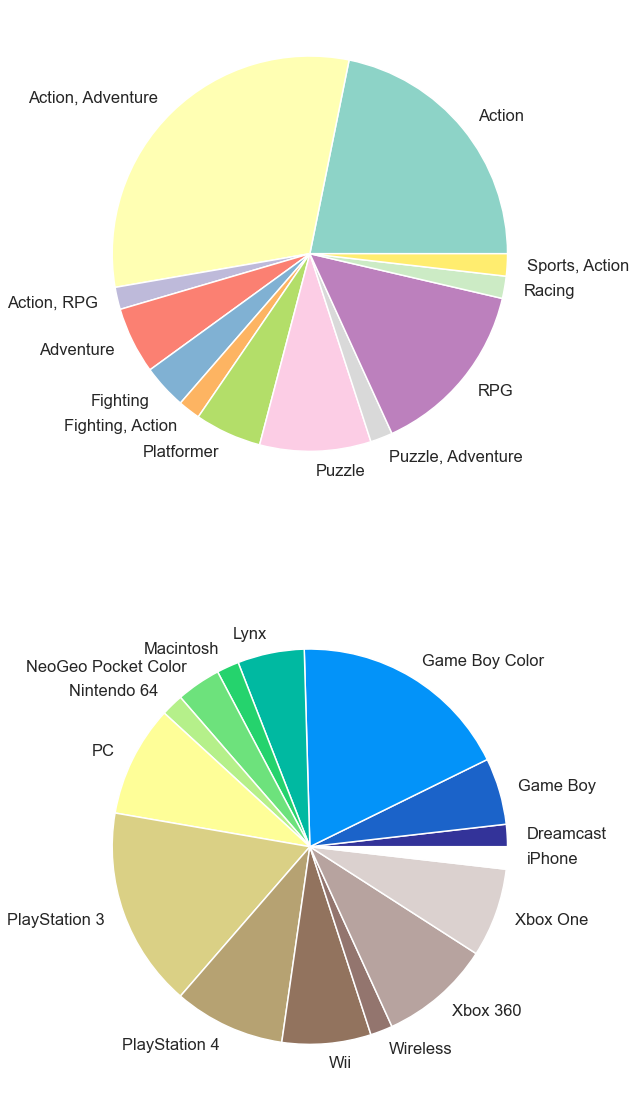

In [36]:
f, ax = plt.subplots(2,1, figsize=(10,20))
master.groupby('genre').size().plot.pie(ax=ax[0],cmap='Set3')
master.groupby('platform').size().plot.pie(ax=ax[1],cmap='terrain')
ax[0].set_ylabel('')
ax[1].set_ylabel('')

In [37]:
#Using this dataset we find out about cyclic structure of game releases, the most popular platforms, some details about game scoring, naming and much more. 

In [38]:
dataset.head()

,score_phrase,title,platform,score,genre,editors_choice,release_year,release_month,release_day,release_date
0,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,9.0,Platformer,Y,2012,9,12,2012-09-12
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,9.0,Platformer,Y,2012,9,12,2012-09-12
2,Great,Splice: Tree of Life,iPad,8.5,Puzzle,N,2012,9,12,2012-09-12
3,Great,NHL 13,Xbox 360,8.5,Sports,N,2012,9,11,2012-09-11
4,Great,NHL 13,PlayStation 3,8.5,Sports,N,2012,9,11,2012-09-11


In [39]:
dataset['Polarity_Rating'] = data['score'].apply(lambda x:'Positive'if x >= 7 else('Negative'if x < 4 else 'Neutral'))

In [48]:
dataset.head()

,score_phrase,title,platform,score,genre,editors_choice,release_year,release_month,release_day,release_date,Polarity_Rating
0,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,9.0,Platformer,Y,2012,9,12,2012-09-12,Positive
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,9.0,Platformer,Y,2012,9,12,2012-09-12,Positive
2,Great,Splice: Tree of Life,iPad,8.5,Puzzle,N,2012,9,12,2012-09-12,Positive
3,Great,NHL 13,Xbox 360,8.5,Sports,N,2012,9,11,2012-09-11,Positive
4,Great,NHL 13,PlayStation 3,8.5,Sports,N,2012,9,11,2012-09-11,Positive


In [49]:
dataset.tail()

,score_phrase,title,platform,score,genre,editors_choice,release_year,release_month,release_day,release_date,Polarity_Rating
18620,Good,Tokyo Mirage Sessions #FE,Wii U,7.6,RPG,N,2016,6,29,2016-06-29,Positive
18621,Amazing,LEGO Star Wars: The Force Awakens,PlayStation 4,9.0,"Action, Adventure",Y,2016,6,29,2016-06-29,Positive
18622,Mediocre,Star Ocean: Integrity and Faithlessness,PlayStation 4,5.8,RPG,N,2016,6,28,2016-06-28,Neutral
18623,Masterpiece,Inside,Xbox One,10.0,Adventure,Y,2016,6,28,2016-06-28,Positive
18624,Masterpiece,Inside,PC,10.0,Adventure,Y,2016,6,28,2016-06-28,Positive


In [41]:
%matplotlib inline

<AxesSubplot:xlabel='Polarity_Rating', ylabel='count'>

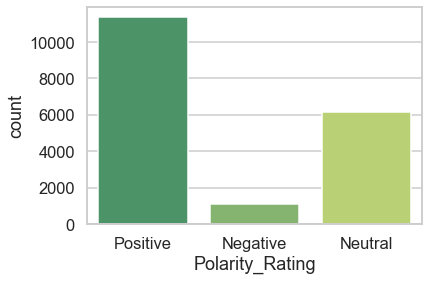

In [42]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating', data=dataset, palette='summer')

In [43]:
dataset['Polarity_Rating'].value_counts()

Positive    11372
Neutral      6173
Negative     1079
Name: Polarity_Rating, dtype: int64

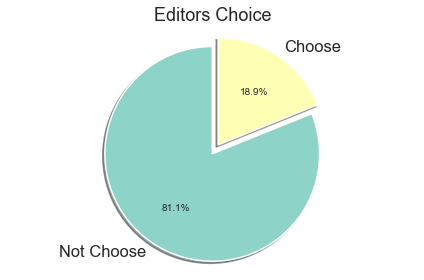

In [44]:
sizes = [dataset.editors_choice.value_counts()[0], dataset.editors_choice.value_counts()[1]]
labels = ['Not Choose', 'Choose']

explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.set_title('Editors Choice')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
plt.tight_layout()
plt.show()

In [45]:
dataset.editors_choice.value_counts()

N    15108
Y     3517
Name: editors_choice, dtype: int64